# Airy Disk with simple fluctuations + pairwise

- 円形開口の平面波を作り (pupa)-> ガウシアン場（位相のみ）をかませ(pupa -> pupa) -> pairwiseで測定する 

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pylab
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('./../src/')

In [4]:
#from vcr/src
import plain_wave as pw
import mask_circular as mc
import no_coronagraph as nc
import pupil_grand as pg
import AO as ao_now

## 星からの光を作る
星や惑星からの光は、位相のついた平面波で表される。いま微妙にoff axisを考えてみよう。

In [5]:
n=256 # sampling rate at a pupil
#pos_star=[0.5,1.0] #angle in unit of lambda/D
pos_star=[0.01,.01] #angle in unit of lambda/D
pupa = pw.wg_plain_wave(n,pos_star)


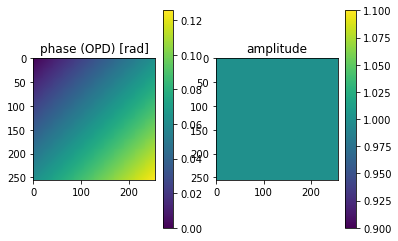

In [6]:
fig = plt.figure()
ax = fig.add_subplot(121)
q=ax.imshow(np.angle(pupa))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
q=ax.imshow(np.abs(pupa))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

## Gaussian Random Field

pupil_grand.pyでは以下のようにガウスランダム場を生成している
ガウシアンランダム場をつくるには,複素場の実部aと虚部bが
- $p(a) = \frac{1}{\sqrt{\pi f(k)}} \exp{\left( - \frac{a^2}{f(k)} \right) } d a $
- $p(b) = \frac{1}{\sqrt{\pi f(k)}} \exp{\left( - \frac{b^2}{f(k)} \right) } d b $

の分布関数に従う（つまりSTD が $\sigma = \sqrt{f(k)/2}$のガウシアン）$c = a + b i$を、フーリエ変換すれば良い。

もし作りたい場cが実数場の時には
- $a(k) = - a(k)$
- $b(k) = - b(-k)$
の条件を課す。実際には行列の半分+1列をReal IFFTにいれる。

In [7]:
var_field=(np.pi/4.0)*(np.pi/4.0) #位相乱れの分散
var_field = 0.01
alpha=-3.0 #power
rmin=10.0 # softening radius in unit of pixel
pupa=pg.p2p_grand_phase_powerlaw(pupa,var_field=var_field,alpha=alpha,rmin=rmin)

(256, 256)


./../src/pupil_grand.py:35: RuntimeWarning: divide by zero encountered in power
  f=rm**(alpha)


## 円形開口マスク
望遠鏡のマスクはpupil to pupilの関数である

In [8]:
pupa=mc.p2p_circular(pupa)

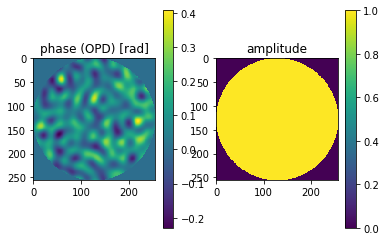

In [9]:
#表示

fig = plt.figure()
ax = fig.add_subplot(121)
q=ax.imshow(np.angle(pupa))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
q=ax.imshow(np.abs(pupa))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

In [10]:
## E_ab Estimation
## pairwiseで推定する 
## Eq (6) ~ Eq(11) in "A Give'on et al. 2007" (http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1322594)

/Users/masatakaaizawa/.pyenv/versions/3.4.3/lib/python3.4/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/masatakaaizawa/.pyenv/versions/3.4.3/lib/python3.4/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/masatakaaizawa/.pyenv/versions/3.4.3/lib/python3.4/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Estimation


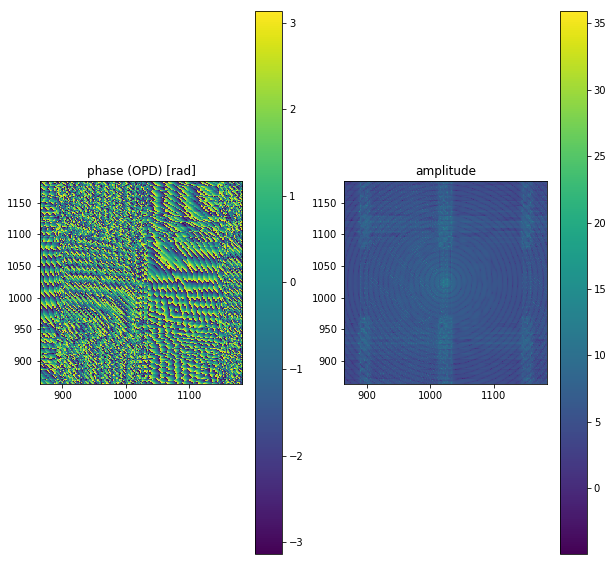

True


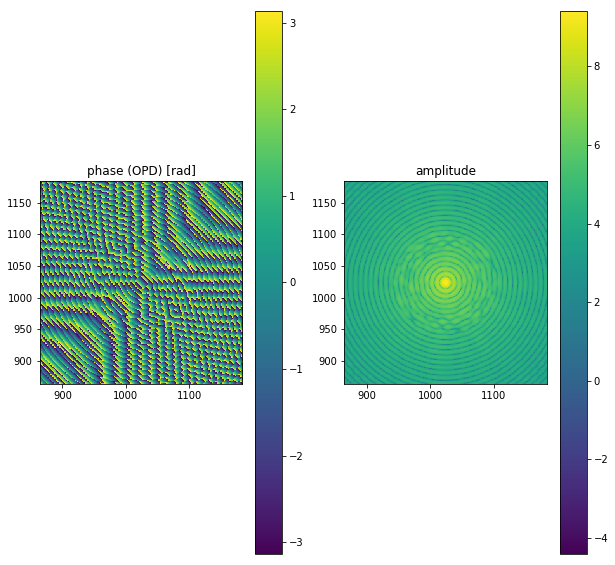

In [21]:
## I_{1} and psi_{1}
ao_size = 32
exprat=8 
psi, pupa_psi = ao_now.p2p_sinc_sinc_sin(pupa, ao_size, .2, 0.05, 0.05, 0.2, np.pi/2)
psi_min, pupa_psi_min = ao_now.p2p_sinc_sinc_sin(pupa, ao_size, -.2, 0.05, 0.05, 0.2, np.pi/2)
foca = nc.cf_no_coronagraph(pupa_psi,exprat=exprat)
foca_min = nc.cf_no_coronagraph(pupa_psi_min,exprat=exprat)


## I_{2} and psi_{2}
psi_2, pupa_psi_2 = ao_now.p2p_sinc_sinc_sin(pupa, ao_size, .2, 0.05, 0.05, 0.2, 0)
psi_min_2, pupa_psi_min_2 = ao_now.p2p_sinc_sinc_sin(pupa, ao_size, -.2, 0.05, 0.05, 0.2, 0)
foca_2 = nc.cf_no_coronagraph(pupa_psi_2,exprat=exprat)
foca_min_2 = nc.cf_no_coronagraph(pupa_psi_min_2,exprat=exprat)


## Eq(9)

C_psi = (1j)*nc.cf_no_coronagraph(psi,exprat=exprat)
C_psi_2 = (1j)*nc.cf_no_coronagraph(psi_2,exprat=exprat)
C_psi_real, C_psi_img = C_psi.real, C_psi.imag
C_psi_2_real, C_psi_2_img = C_psi_2.real, C_psi_2.imag
norm_angle = np.angle(C_psi)/np.angle(C_psi_2)
foca_1_diff = (foca)**2 - (foca_min)**2
foca_2_diff = (foca_2)**2 - (foca_min_2)**2

Eb_est_re = (foca_1_diff*C_psi_2_img - foca_2_diff * C_psi_img)/(4*(C_psi_real * C_psi_2_img - C_psi_img * C_psi_img)) 
Eb_est_img = (foca_1_diff*C_psi_2_real - foca_2_diff * C_psi_real)/(4*(C_psi_real * C_psi_2_img - C_psi_img * C_psi_img))  
Eb_est = Eb_est_re + Eb_est_img * (1j)
nx=foca.shape[0]
ny=foca.shape[1]

close_in = 20
## Estimation plot
print ("Estimation")
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
plt.xlim(nx/2-close_in*exprat,nx/2+close_in*exprat)
plt.ylim(ny/2-close_in*exprat,ny/2+close_in*exprat)
q=ax.imshow(np.angle(Eb_est))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
plt.xlim(nx/2-close_in*exprat,nx/2+close_in*exprat)
plt.ylim(ny/2-close_in*exprat,ny/2+close_in*exprat)
q=ax.imshow(np.log10(np.abs(Eb_est)**2))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

## True value plot
print ("True")
foca_true = nc.cf_no_coronagraph(pupa,exprat=exprat)
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
plt.xlim(nx/2-close_in*exprat,nx/2+close_in*exprat)
plt.ylim(ny/2-close_in*exprat,ny/2+close_in*exprat)
q=ax.imshow(np.angle(foca_true))
plt.title("phase (OPD) [rad]")
plt.colorbar(q)
ax = fig.add_subplot(122)
plt.xlim(nx/2-close_in*exprat,nx/2+close_in*exprat)
plt.ylim(ny/2-close_in*exprat,ny/2+close_in*exprat)
q=ax.imshow(np.log10(np.abs(foca_true)**2))
plt.title("amplitude")
plt.colorbar(q)
plt.show()

In [ ]:
##惜しい!!